# 1. Constant gaussian white noise (when we can talk about concentration)


$$
\frac{da}{dt} = P + \frac{\lambda_a \cdot a}{1 + k_a \cdot a} - \eta_a \cdot a - \mu_a \cdot a b
$$
$$
\frac{db}{dt} = N + \frac{\lambda_b \cdot b}{1 + k_b \cdot b} - \eta_b \cdot b - \mu_b \cdot a b
$$

Where:
- $a, b$: dynamic variables (e.g., population levels, concentrations)
- $P, N$: external input/production rates
- $\lambda_a, \lambda_b$: growth rate constants
- $k_a, k_b$: saturation constants (Hill-type terms)
- $\eta_a, \eta_b$: decay or dilution rates
- $\mu_a, \mu_b$: interaction strengths between $a$ and $b$

We firsty considers noise over N and P.

## 1.1 Symmetrical system

**ATTENTION** Pour rester dans le régime de bistabilité, une condition nécessaire (mais pas suffisante) est que $$P,N<1.25$$

By symmetrical, we mean that all constants $\lambda, \eta, \mu$ are equal for a and b. 
We assume there exists intrinsic fluctuations on the entries
. As fluctuations are assumed to be independants btw each others wrt to time and space (white), and considering CLTn we choose a gaussian white noise, where the concentration value is drawn from $N=N_{grid}+\eta_N$. For now, the noise is time independant


Here the frontier equation is just $P=N$

### 1.1.1 Dynamics and plane classification

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
from itertools import product

# --- Parameters ---
eta_a = 0.1
eta_b = 0.1
mu_a = 0.2
mu_b = 0.2
k_a = 0.7
k_b = 0.7
lambda_a = 1.0
lambda_b = 1.0

# --- Parameter grid for numerical integration ---
nb_of_points = 50
P_grid = np.linspace(0.0, 1.25, nb_of_points)  # Ensure P is positive
N_grid = np.linspace(0.0, 1.25, nb_of_points)  # Ensure N is positive

# Noise parameters
noise_sigma = 0.2  # standard deviation of the Gaussian noise

# Time span and initial condition for the ODE
t_span_full = (0, 150)
y0 = [1e-6, 1e-6]  # Initial a and b

In [39]:
# --- System equations ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# Integration helper function
def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]  # Return final a and b



# --- Generate data ---
results = []  # to store (noisy P, noisy N, steady state a, steady state b)
for P, N in tqdm(product(P_grid, N_grid), total=nb_of_points*nb_of_points):
    # Add independent Gaussian white noise to each grid coordinate
    noisy_P = max(0.0, P + np.random.normal(loc=0, scale=noise_sigma))  # Ensure P stays positive
    noisy_N = max(0.0, N + np.random.normal(loc=0, scale=noise_sigma))  # Ensure N stays positive
    
    # Integrate the ODE dynamics with the noisy parameters
    a_final, b_final = integrate_ode(noisy_P, noisy_N, y0, t_span_full)
    
    # Clip values into a reasonable range (0 to 10) for visualization
    results.append((noisy_P, noisy_N, np.clip(a_final, 0, 10), np.clip(b_final, 0, 10)))

results = np.array(results)
P_plot = results[:, 0]
N_plot = results[:, 1]
a_low_plot = results[:, 2]
b_low_plot = results[:, 3]





  0%|          | 0/2500 [00:00<?, ?it/s]

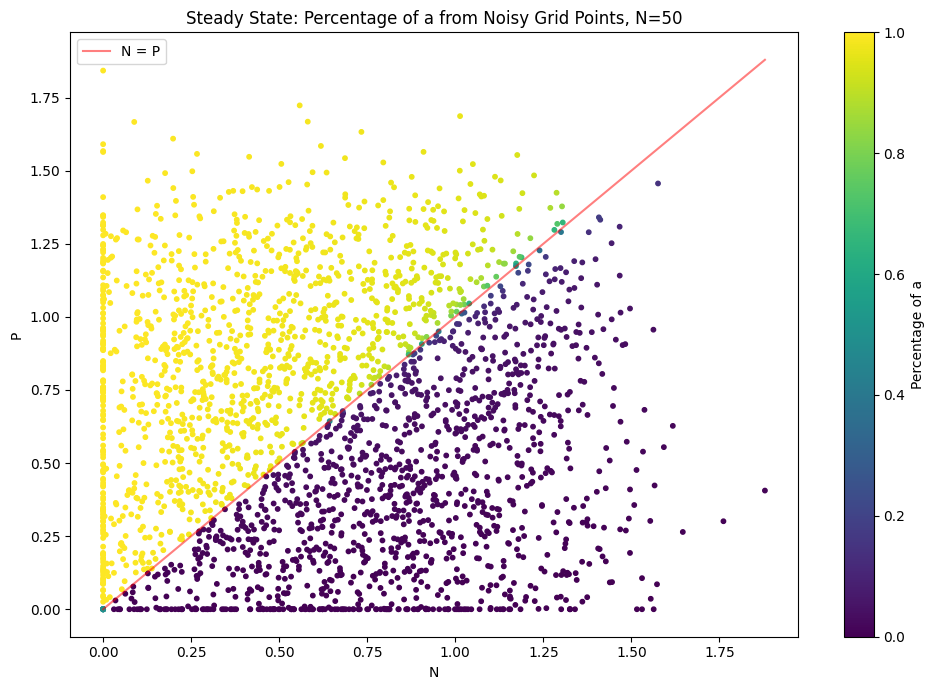

In [40]:
# --- Plot the phase diagram using the noisy grid points ---
fig, ax = plt.subplots(figsize=(10, 7))

# Compute percentage of a (a / (a + b))
a_percentage = a_low_plot / (a_low_plot + b_low_plot + 1e-10)  # Avoid division by zero

# Plot with a single colormap based on the percentage of a
sc = ax.scatter(N_plot, P_plot, c=a_percentage, cmap='viridis', s=10, marker='o')
ax.set_title(f"Steady State: Percentage of a from Noisy Grid Points, N={nb_of_points}")
ax.set_xlabel("N")
ax.set_ylabel("P")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Percentage of a")
# Plot the diagonal line N = P
min_val = min(np.min(N_plot), np.min(P_plot))
max_val = max(np.max(N_plot), np.max(P_plot))
ax.plot([min_val, max_val], [min_val, max_val], color='red',alpha=0.5,  label='N = P')

ax.legend()


plt.tight_layout()
plt.show()

There is an important point to consider : a condition for the bistability is that $P,N<1.25$. We can indeed see that approaching P=N=1.25, there are more and more 50/50 final state, creation a cone oriented toward the upper right which contain more and more non decided neurons.

Up to now, we've used a fully symmetrical version of the system, whose parameters are symetrical 
$$ \begin{aligned} \eta_a = \eta_b &= 0.1 \\ \mu_a =\mu_b &= 0.2 \\ k_a = k_b &= 0.7 \\ \lambda_a = \lambda_b &= 1.0 \end{aligned} $$
There is always a WTA, even for close initial P and N values, yet the more P and N are initially close, the more it takes time to reach the 0-100 final concentration.
For P=N, this amount ouf time is infinite and both species end up at the same concetration 50/50 of a and b (first graph)
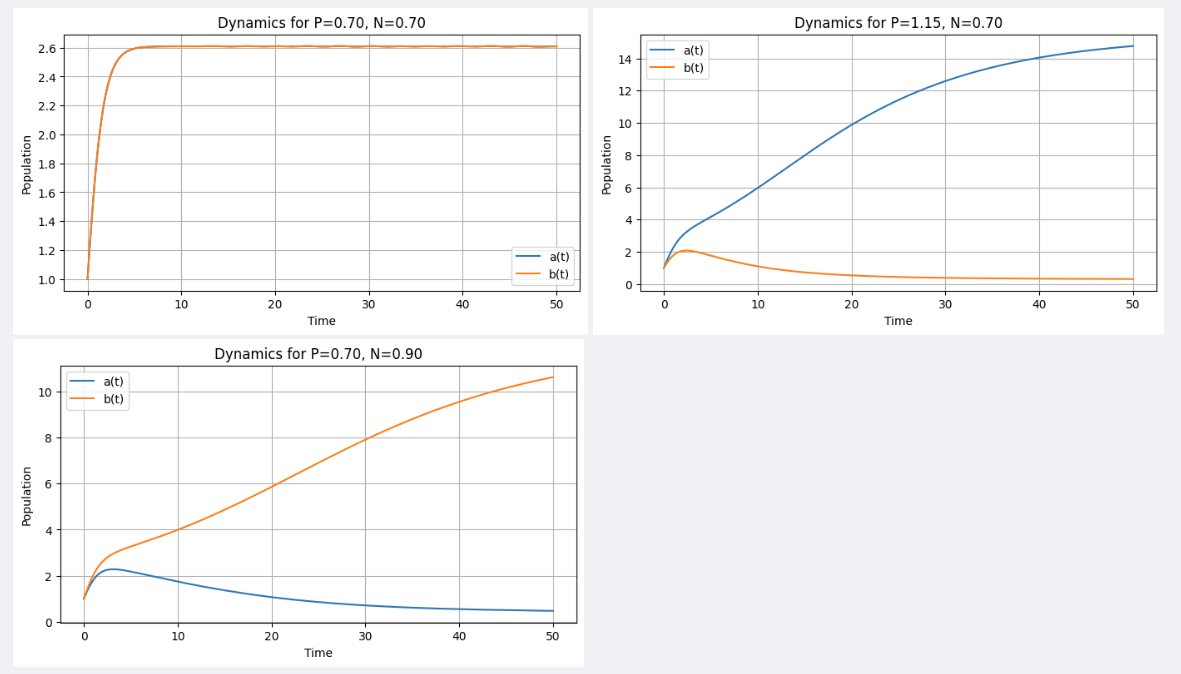

This is no surprise : the higher is the difference between N and P (ie the further away we are from the diagonal N=P), the fastest it takes for one species to win over the other. For N=P, this time is infinite. 

We should can expect a power law for the time to converge depending on the initial concentration P and N, ie the position in the configurational space  $$t_f\propto|P-N|^{-\alpha}$$

### 1.1.2 Density profile analysis of the frontier, wrt the computation time

**(a) Without noise**

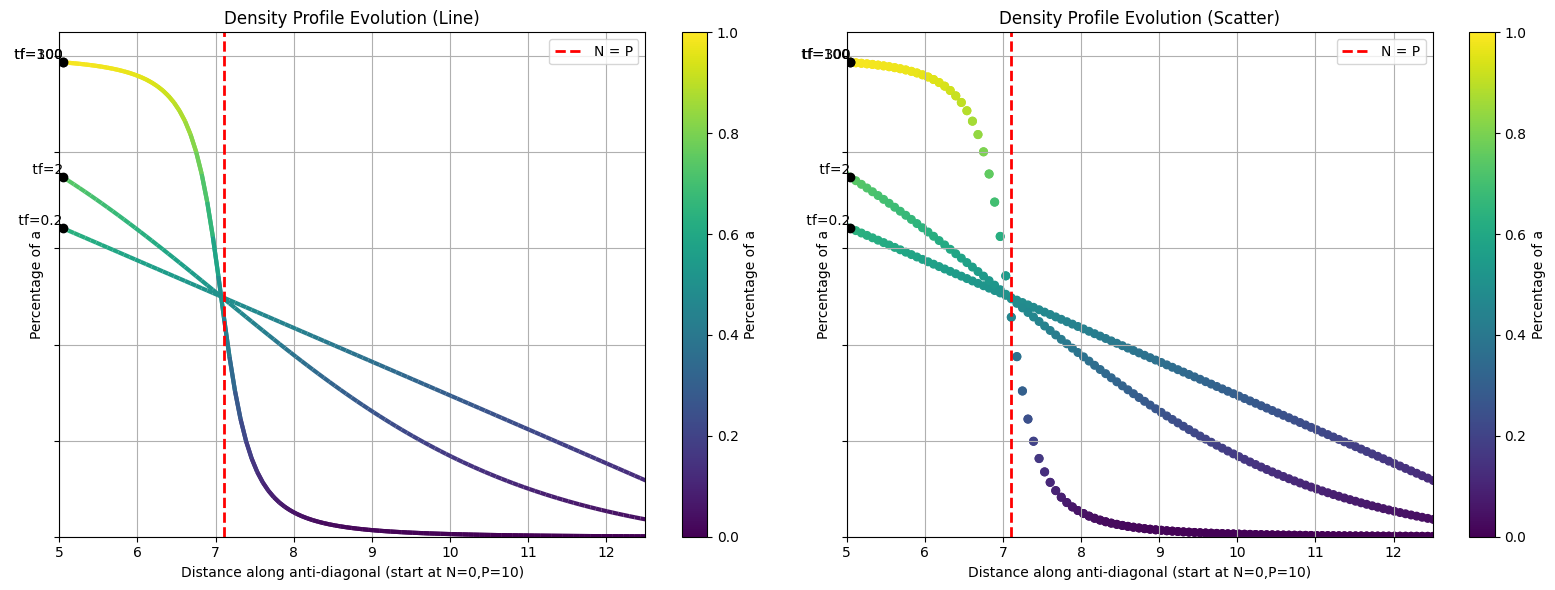

Smooth curves, no false nor true positive, the more you wait, the less ambivalent the classification is (ie the more decided the final system is).
There for convergence time >300, the computer makes no error.


**(b) With noise**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.collections import LineCollection
from tqdm import tqdm

# --- System parameters ---
eta_a, eta_b = 0.1, 0.1
mu_a, mu_b   = 0.2, 0.2
k_a, k_b     = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

num_points = 200

# --- Noise & integration setup ---
noise_sigma = 0.1
y0 = [1e-6, 1e-6]

# --- Final times to compare transient vs steady ---
tf_list = [300,1000]

# Set desired plot ranges here:
x_min, x_max = 5, 12.5
y_min_plot, y_max_plot = 0, 1.05


In [13]:
# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0, args=(P, N),
                    t_eval=t_eval, method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]

# --- Parameterize anti-diagonal from (N=0, P=10) to (N=10, P=0) ---

t_line = np.linspace(0, 1, num_points)
N_diag = 10 * t_line
P_diag = 10 * (1 - t_line)
distance_diag = 10 * np.sqrt(2) * t_line



# --- Compute percentage-of-a profiles ---
profiles = {}
for tf in tqdm(tf_list, desc="Processing tf values"):
    profile = np.zeros(num_points)
    for i in range(num_points):
        noisy_N = max(0, N_diag[i] + np.random.normal(scale=noise_sigma))
        noisy_P = max(0, P_diag[i] + np.random.normal(scale=noise_sigma))
        a_f, b_f = integrate_ode(noisy_P, noisy_N, y0, (0, tf))
        profile[i] = np.clip(a_f / (a_f + b_f + 1e-10), 0, 1)
    profiles[tf] = profile

# --- Prepare colormap ---
all_vals = np.concatenate(list(profiles.values()))
norm = plt.Normalize(vmin=all_vals.min(), vmax=all_vals.max())
cmap = plt.cm.viridis

# --- Compute where N = P on the anti-diagonal ---
idx_eq = np.argmin(np.abs(N_diag - P_diag))
distance_eq = distance_diag[idx_eq]



Processing tf values: 100%|██████████| 2/2 [01:20<00:00, 40.33s/it]


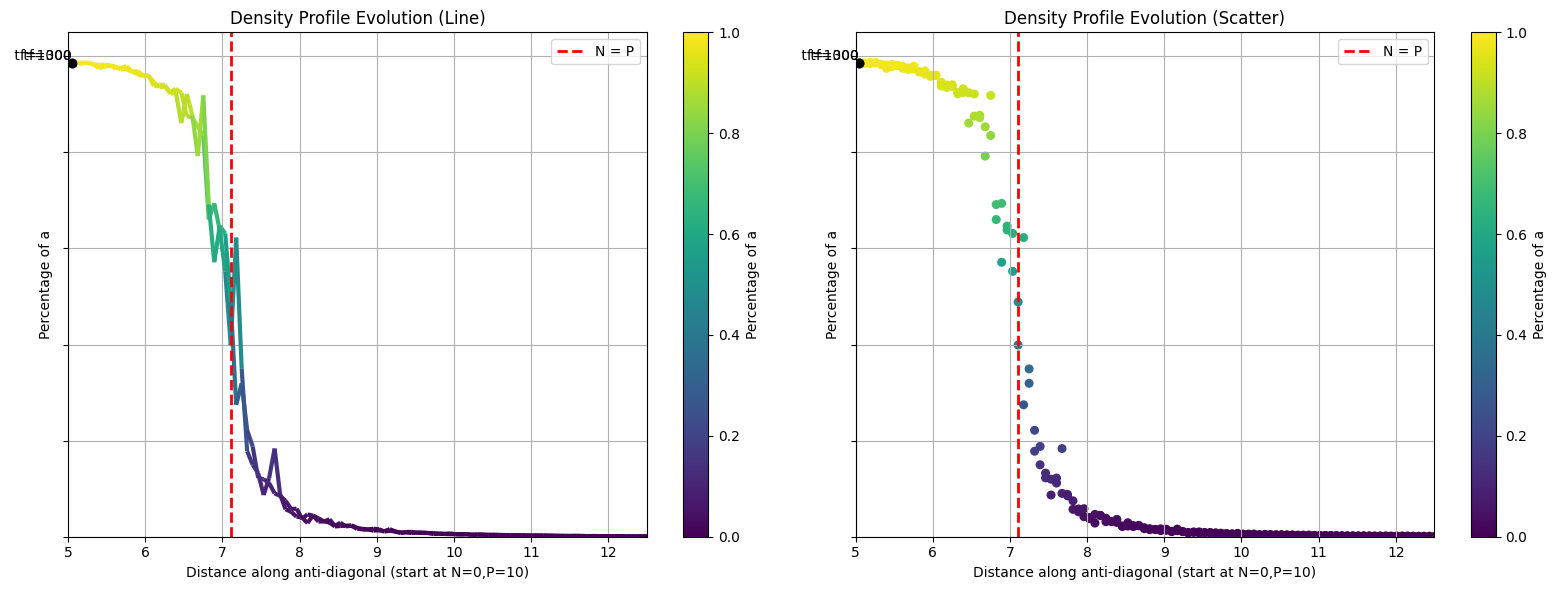

In [14]:
# --- Plotting ---

# Find an index for annotation in the visible window
annotate_index = np.where((distance_diag >= x_min) & (distance_diag <= x_max))[0][0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Line plot with colored segments
for tf, profile in profiles.items():
    points   = np.vstack([distance_diag, profile]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    seg_colors = [(cmap(norm((profile[i] + profile[i+1]) / 2))) for i in range(len(profile)-1)]
    lc = LineCollection(segments, colors=seg_colors, linewidths=3)
    ax1.add_collection(lc)
    # annotate at the first visible point
    d0 = distance_diag[annotate_index]
    p0 = profile[annotate_index]
    ax1.plot(d0, p0, 'ko')
    ax1.text(d0, p0, f' tf={tf}', va='bottom', ha='right')

# Add the N = P frontier line
ax1.axvline(distance_eq, color='red', linestyle='--', linewidth=2, label='N = P')

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min_plot, y_max_plot)
ax1.set_xlabel("Distance along anti-diagonal (start at N=0,P=10)")
ax1.set_ylabel("Percentage of a")
ax1.set_title("Density Profile Evolution (Line)")
ax1.grid(True)
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])
plt.colorbar(sm1, ax=ax1, label="Percentage of a")
ax1.legend()

# Remove y-axis tick labels
ax1.set_yticklabels([])

# Scatter plot
for tf, profile in profiles.items():
    ax2.scatter(distance_diag, profile, c=profile, cmap=cmap, norm=norm, s=30)
    d0 = distance_diag[annotate_index]
    p0 = profile[annotate_index]
    ax2.plot(d0, p0, 'ko')
    ax2.text(d0, p0, f' tf={tf}', va='bottom', ha='right')

# Add the N = P frontier line
ax2.axvline(distance_eq, color='red', linestyle='--', linewidth=2, label='N = P')

ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min_plot, y_max_plot)
ax2.set_xlabel("Distance along anti-diagonal (start at N=0,P=10)")
ax2.set_ylabel("Percentage of a")
ax2.set_title("Density Profile Evolution (Scatter)")
ax2.grid(True)
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])
plt.colorbar(sm2, ax=ax2, label="Percentage of a")
ax2.legend()

# Remove y-axis tick labels
ax2.set_yticklabels([])

plt.tight_layout()
plt.show()




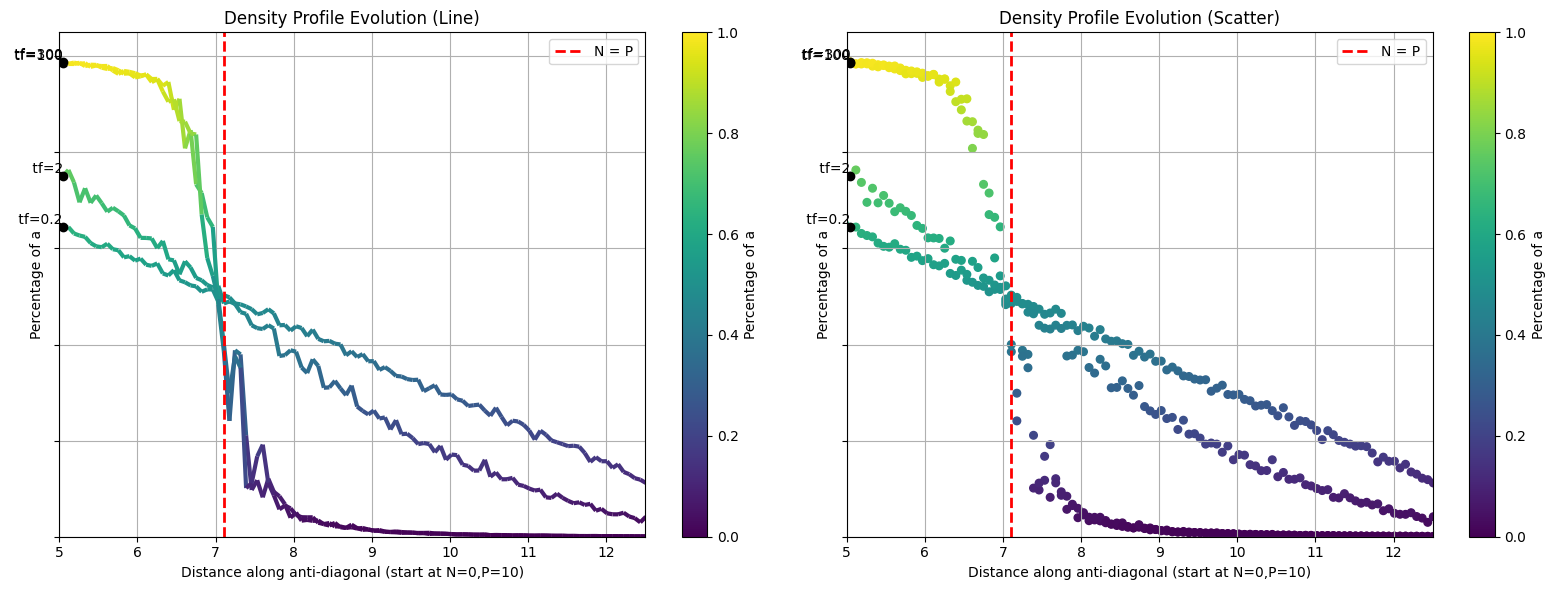

We can see that early stopping freeze most of neurons in a undecided state. The biggest is the noise, the more probable is to find false positive of the classification nearby the frontier, ie, errors.

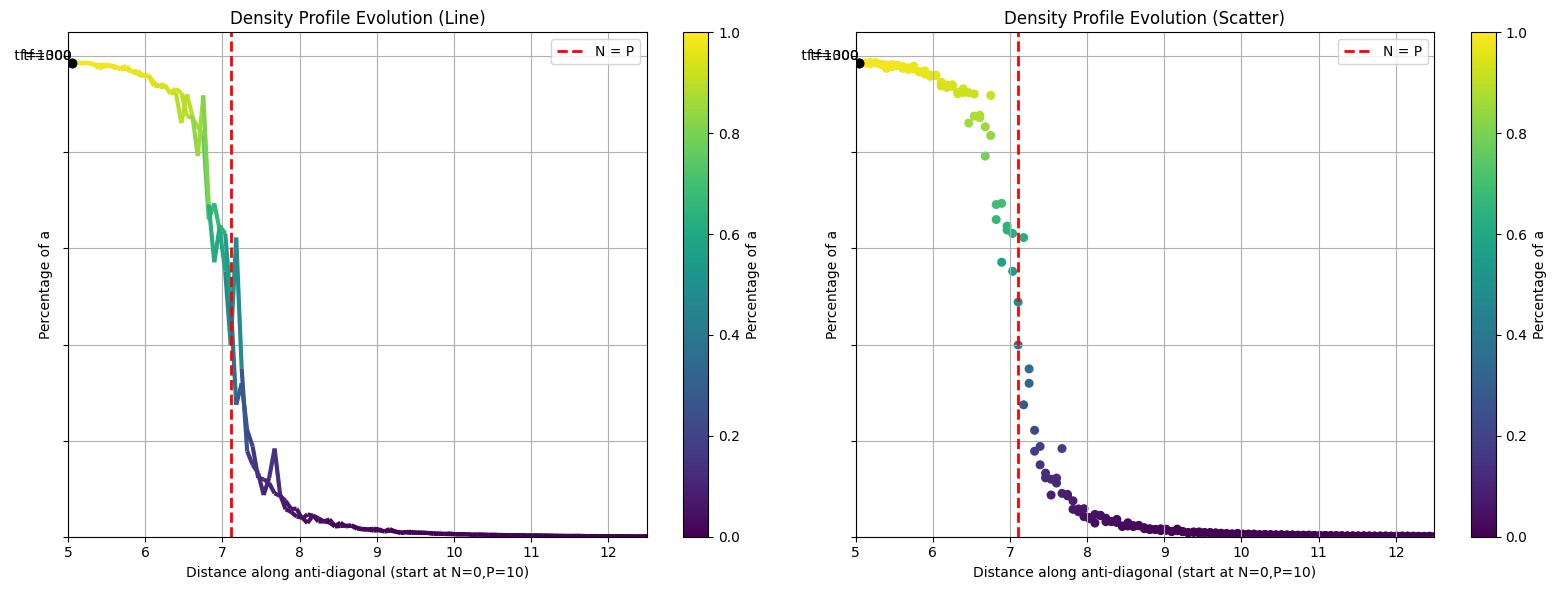

# montrer que temps au voisinage bifurcation diverge, lineariser puis voir (strogatz)
# quantifier faux positifs et négatifs
# avoir des résultats analhytiques
# regarder mail David nb de solutions sans les calculer µ
# conf thermo stochastique jeudi matin 
# programme dans dropbox


There is no significative difference between tf=300 and tf =1000.


### 1.1.3 Convergence time

**ATTENTION** Pour rester dans le régime de bistabilité, une condition nécessaire (mais pas suffisante) est que $$P,N<1.25$$

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# --- Noise and grid setup ---
noise_sigma = 0.2
nb_of_points_grid = 40
P_values = np.linspace(0, 1.25, nb_of_points_grid)
N_values = np.linspace(0, 1.25, nb_of_points_grid)
all_points = [(P, N) for P in P_values for N in N_values]

# --- Time span for single tf ---
tf_single     = 1000
t_eval_single = np.linspace(0, tf_single, 500)

Integrating percentage of a(t): 100%|██████████| 1600/1600 [01:43<00:00, 15.42it/s]


Percentage of neurons with final a‐percentage within ±5.0% of 50%: 0.44%


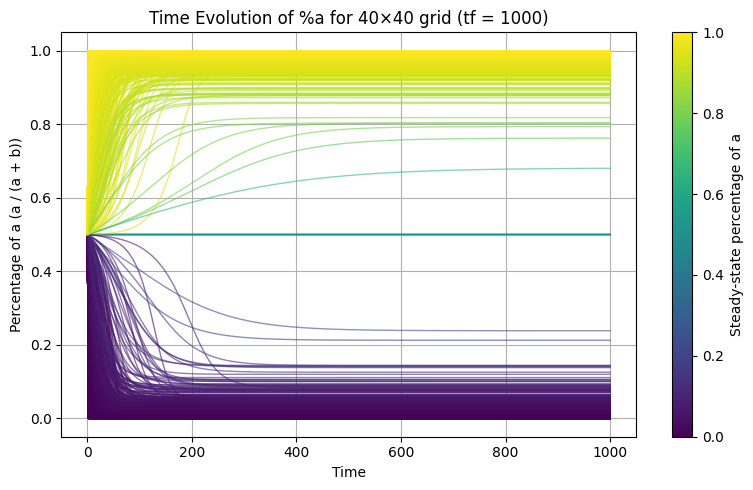

In [31]:
# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Integration helper ---
def integrate_system(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 500)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.t, sol.y[0], sol.y[1]  # times, a(t), b(t)



# --- Colormap for percentage of a ---
cmap_y = plt.cm.viridis
norm_y = plt.Normalize(vmin=0.0, vmax=1.0)

# --- Tolerance around 50% for counting neurons ---
tol = 0.05  # i.e. count those with |pct_a - 0.5| < 0.05

# --- Plotting setup ---
fig, ax = plt.subplots(figsize=(8, 5))

# we'll collect final percentages to compute the counter
final_pcts = []

for P0, N0 in tqdm(all_points, desc="Integrating percentage of a(t)"):
    # add Gaussian noise to inputs
    noisy_P = max(0, P0 + np.random.normal(scale=noise_sigma))
    noisy_N = max(0, N0 + np.random.normal(scale=noise_sigma))
    
    # integrate up to tf_single
    t, a_t, b_t = integrate_system(noisy_P, noisy_N, 
                                   y0=[1e-6, 1e-6], 
                                   t_span=(0, tf_single),
                                   t_eval=t_eval_single)
    # compute percentage of a
    pct_a = a_t / (a_t + b_t + 1e-10)
    
    # store final percentage
    final_pcts.append(pct_a[-1])
    
    # pick color by final percentage
    color = cmap_y(norm_y(pct_a[-1]))
    
    # plot percentage vs time
    ax.plot(t, pct_a, color=color, lw=1, alpha=0.6)

# compute how many are approximately at 50%
final_pcts = np.array(final_pcts)
mask_50 = np.abs(final_pcts - 0.5) < tol
percent_50 = mask_50.sum() / mask_50.size * 100

# display the result
print(f"Percentage of neurons with final a‐percentage within ±{tol*100:.1f}% of 50%: {percent_50:.2f}%")

# labels and colorbar
ax.set_xlabel("Time")
ax.set_ylabel("Percentage of a (a / (a + b))")
ax.set_title(f"Time Evolution of %a for {nb_of_points_grid}×{nb_of_points_grid} grid (tf = {tf_single})")
ax.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap_y, norm=norm_y)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Steady‐state percentage of a")

plt.tight_layout()
plt.show()



There is a nice classification, most of neuron ending in the decided state a of b. Nevertheless, there remains some undecided (less than 1%) neuron (50/50 green curves) whose state is 50/50, because either the initial condition was P=N, either we where out of stability, then a=b was a stable fixed point instead of a unstable one.

*This might be an issue*, because so as to ensure bistability, one must add hard constrains on P and N values.
Futhermore, this system takes significantly more time to converge toward a "full decided state" than for the first Rondelez system. 

**Remark** : For the fully symmetric neuron, if one is not considering $P,N<1.25$, then instead of having bistability (full a and full b are stable and a=b is unstable) one has a monostability, in which a=b can be a stable fixed point (see graph below), hence the classification is catastriphic.

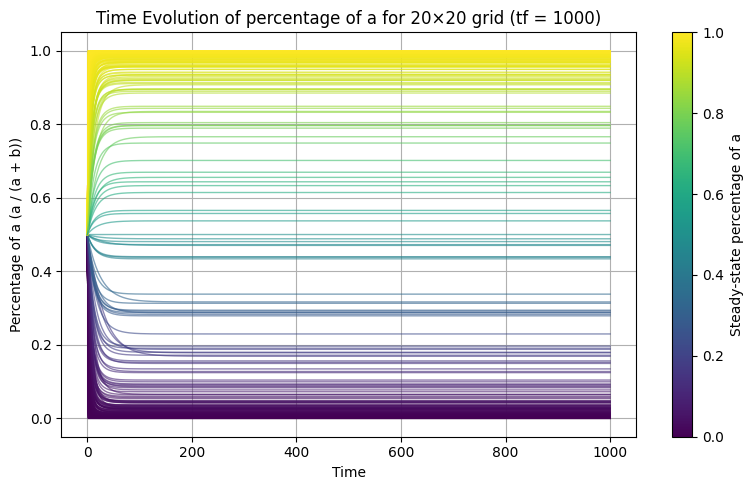

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# --- System parameters ---
eta_a, eta_b       = 0.1, 0.1
mu_a,  mu_b        = 0.2, 0.2
k_a,   k_b         = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

# --- Noise parameters ---
noise_sigma = 0.2  # standard deviation of Gaussian noise on inputs

# --- Integration parameters ---
tf_single      = 1000
t_eval_single  = np.linspace(0, tf_single, 500)

# --- Grid of neurons (P, N values) ---
nb_of_points_grid = 20
P_values          = np.linspace(0, 1.25, nb_of_points_grid)
N_values          = np.linspace(0, 1.25, nb_of_points_grid)
all_neurons       = [(P, N) for P in P_values for N in N_values]

# --- Convergence criterion parameters ---
tol_rate = 1e-3   # threshold on |dp/dt|
M        = 50     # number of consecutive points below threshold





In [96]:
# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a)/(1 + k_a*a) - eta_a*a - mu_a*a*b

def db_dt(a, b, N):
    return N + (lambda_b * b)/(1 + k_b*b) - eta_b*b - mu_b*a*b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Convergence time storage ---
convergence_times = []

print(f"Computing convergence times for grid with {nb_of_points_grid**2} neurons...")
for P0, N0 in tqdm(all_neurons, desc="Integrating neurons"):
    # Add Gaussian white noise and clip to non-negative
    noisy_P = max(P0 + np.random.normal(scale=noise_sigma), 0)
    noisy_N = max(N0 + np.random.normal(scale=noise_sigma), 0)

    # Integrate the system
    sol = solve_ivp(system, (0, tf_single), [1e-6, 1e-6],
                    args=(noisy_P, noisy_N),
                    t_eval=t_eval_single,
                    method="RK45", rtol=1e-8, atol=1e-10)

    a_vals, b_vals = sol.y
    pct_a_vals = a_vals / (a_vals + b_vals + 1e-10)  # percentage of a
    t_vals     = sol.t

    # approximate dp/dt by finite differences
    dt   = t_vals[1] - t_vals[0]
    dpdt = np.diff(pct_a_vals) / dt

    # find first time where |dp/dt| < tol_rate for M consecutive points
    conv_time = tf_single
    for i in range(len(dpdt) - M):
        if np.all(np.abs(dpdt[i:i+M]) < tol_rate):
            conv_time = t_vals[i]
            break

    convergence_times.append(conv_time)

convergence_times = np.array(convergence_times)

# --- Compute percentage of neurons converged over time ---
time_grid = np.linspace(0, tf_single, 500)
percentage_converged = [
    100 * np.sum(convergence_times <= t) / convergence_times.size
    for t in time_grid
]




Computing convergence times for grid with 400 neurons...


Integrating neurons: 100%|██████████| 400/400 [00:16<00:00, 23.79it/s]


In [100]:
# --- Plotting range (user-defined) ---
plot_t_min = 0     # e.g. 0
plot_t_max = 1000    # e.g. 50 (must be <= tf_single)

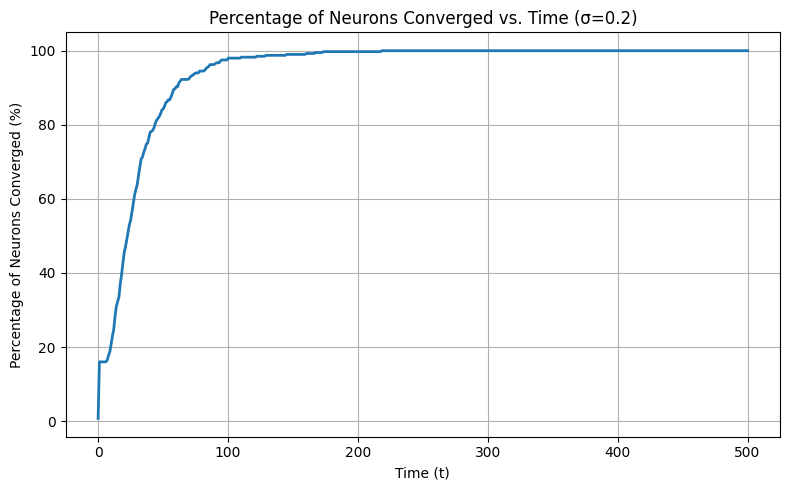

In [101]:
# --- Plot ---
# Mask time and percentage arrays based on plotting range
mask = (time_grid >= plot_t_min) & (time_grid <= plot_t_max)
time_to_plot = time_grid[mask]
percentage_to_plot = np.array(percentage_converged)[mask]


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_to_plot, percentage_to_plot, lw=2)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Percentage of Neurons Converged (%)")
ax.set_title(f"Percentage of Neurons Converged vs. Time (σ={noise_sigma})")
ax.grid(True)
plt.tight_layout()
plt.show()


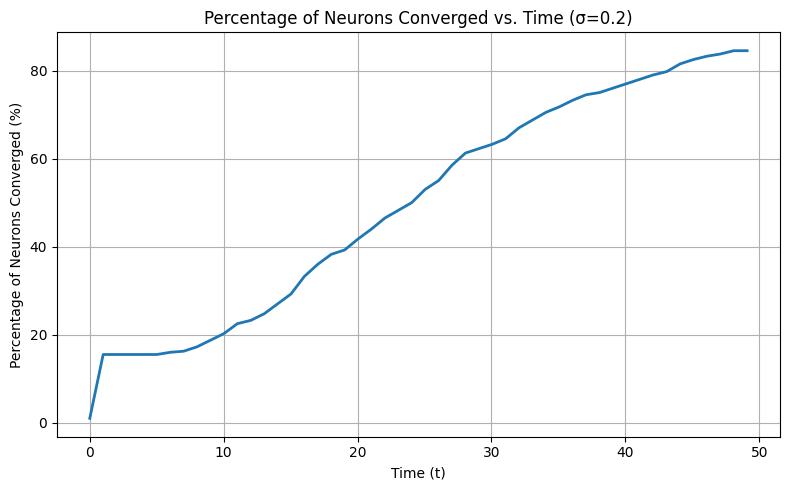

**Q : Why do we have a plateau at $\approx 15%$ ?** 
The WTA decollement initial des 2 courbes est rapide à se mettre en place. En conséquence, les neurones qui avaient des concentration initiales P et N très différents mettent très peu de temps à converger. Peut etre que le second plateau correspond au temps typique de convergence des neurones, la majorité étant dans un état ni trop pres ni trop loin des bassins d'attractions. Pour les autres, ceux qui prennent du temps, c'est une histoire d'être méga loin des bassins d'attraction, ie mega près de P=N... à investiguer

## 1.2 Asymmetrical system


$$
\frac{da}{dt} = P + \frac{\lambda_a \cdot a}{1 + k_a \cdot a} - \eta_a \cdot a - \mu_a \cdot a b
$$
$$
\frac{db}{dt} = N + \frac{\lambda_b \cdot b}{1 + k_b \cdot b} - \eta_b \cdot b - \mu_b \cdot a b
$$


In this section, we want to probe the effect of introducing asymmetry between $\alpha, \eta,\mu$ parameters for a and b, leading to a non N=P frontier.

First, as assumed in our computations, we take $\mu_a=\mu_b$ and $\eta_a=\eta_b$.

- We can define the Michaelis constant $K_a=1/k_a$, which mean the higher $k_a$ is, the lower $K_a$ is, hence, the faster the process reaches full speed saturation.

- $\alpha_a$ holds for the autocathalytic rate

If we want to introduce asymmetry, we can start by probing the effect of $k_a$ and $\alpha_a$


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
from itertools import product

# --- Parameters ---
eta_a = 0.1
eta_b = 0.1
mu_a = 0.2
mu_b = 0.2
k_a = 0.7
k_b = 0.7
lambda_a = 1.0
lambda_b = 1.0

# --- Parameter grid for numerical integration ---
nb_of_points = 30
P_grid = np.linspace(0.0, 2.0, nb_of_points)  # Ensure P is positive
N_grid = np.linspace(0.0, 2.0, nb_of_points)  # Ensure N is positive

# Noise parameters
noise_sigma = 0.2  # standard deviation of the Gaussian noise

# Time span and initial condition for the ODE
t_span_full = (0, 100)
y0 = [1e-6, 1e-6]  # Initial a and b

In [25]:
# --- System equations ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# Integration helper function
def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]  # Return final a and b



# --- Generate data ---
results = []  # to store (noisy P, noisy N, steady state a, steady state b)
for P, N in tqdm(product(P_grid, N_grid), total=nb_of_points*nb_of_points):
    # Add independent Gaussian white noise to each grid coordinate
    noisy_P = max(0.0, P + np.random.normal(loc=0, scale=noise_sigma))  # Ensure P stays positive
    noisy_N = max(0.0, N + np.random.normal(loc=0, scale=noise_sigma))  # Ensure N stays positive
    
    # Integrate the ODE dynamics with the noisy parameters
    a_final, b_final = integrate_ode(noisy_P, noisy_N, y0, t_span_full)
    
    # Clip values into a reasonable range (0 to 10) for visualization
    results.append((noisy_P, noisy_N, np.clip(a_final, 0, 10), np.clip(b_final, 0, 10)))

results = np.array(results)
P_plot = results[:, 0]
N_plot = results[:, 1]
a_low_plot = results[:, 2]
b_low_plot = results[:, 3]


  0%|          | 0/900 [00:00<?, ?it/s]

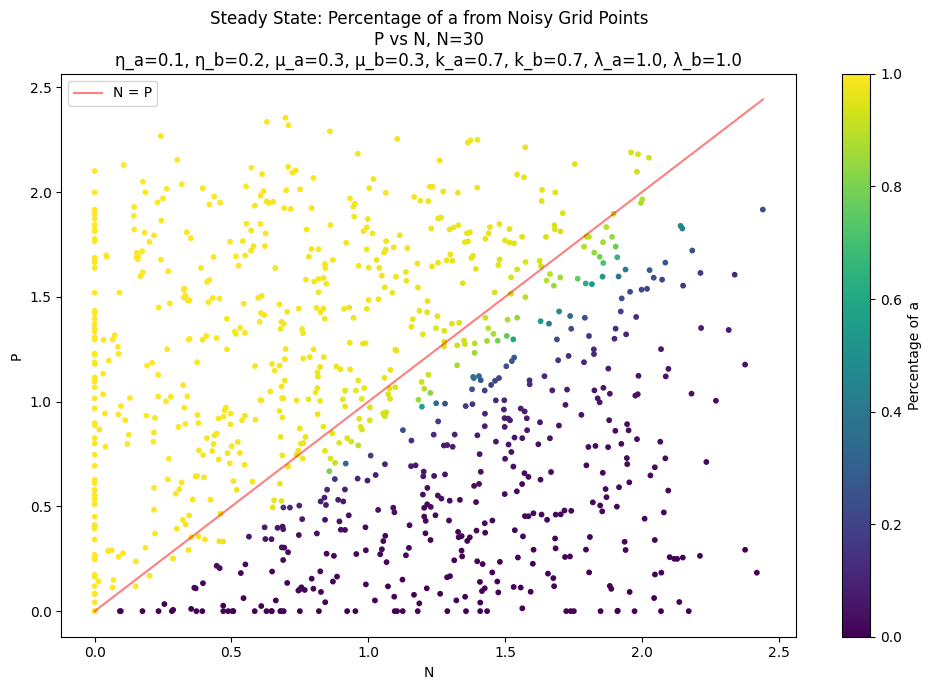

In [38]:
# --- Plot the phase diagram using the noisy grid points ---
fig, ax = plt.subplots(figsize=(10, 7))

# Compute percentage of a (a / (a + b))
a_percentage = a_low_plot / (a_low_plot + b_low_plot + 1e-10)  # Avoid division by zero

# Plot with a single colormap based on the percentage of a
# Build dynamic title with all parameters
title = (
    f"Steady State: Percentage of a from Noisy Grid Points\n"
    f"P vs N, N={nb_of_points}\n"
    f"η_a={eta_a}, η_b={eta_b}, μ_a={mu_a}, μ_b={mu_b}, "
    f"k_a={k_a}, k_b={k_b}, λ_a={lambda_a}, λ_b={lambda_b}"
)

# Plot with a single colormap based on the percentage of a
sc = ax.scatter(N_plot, P_plot, c=a_percentage, cmap='viridis', s=10, marker='o')
ax.set_title(title)
ax.set_xlabel("N")
ax.set_ylabel("P")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Percentage of a")
# Plot the diagonal line N = P
min_val = min(np.min(N_plot), np.min(P_plot))
max_val = max(np.max(N_plot), np.max(P_plot))
ax.plot([min_val, max_val], [min_val, max_val], color='red',alpha=0.5,  label='N = P')

ax.legend()


plt.tight_layout()
plt.show()

### $\mu_a$ and $\mu_b$

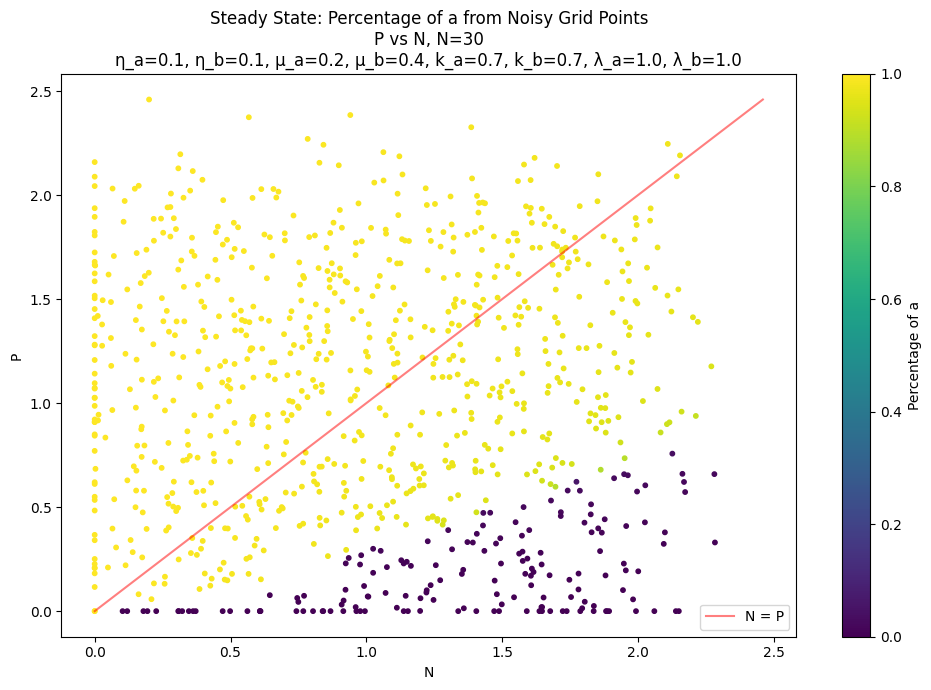
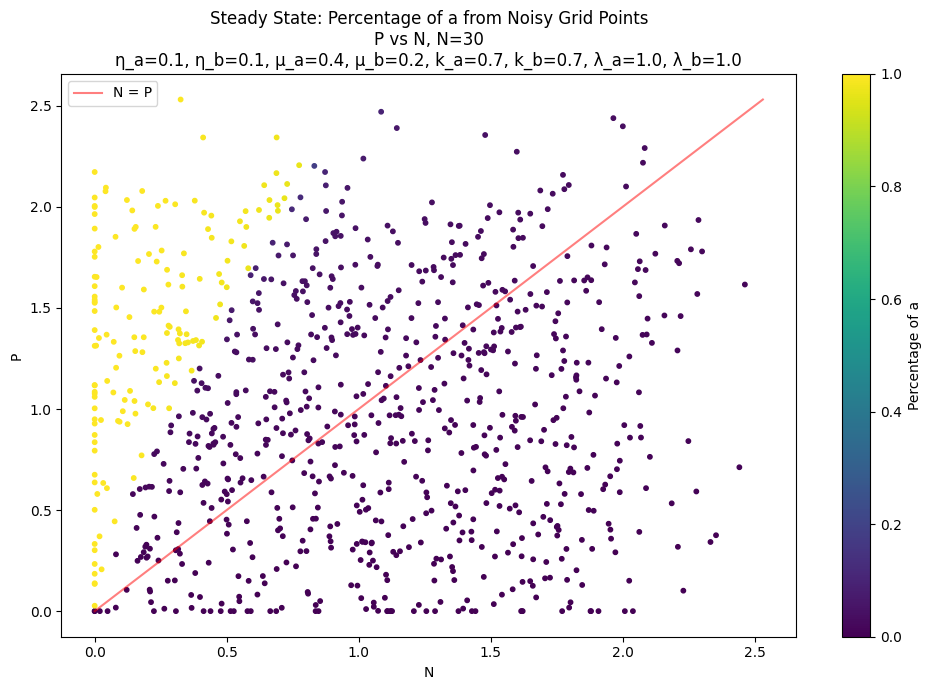

### $k_a$ and $k_b$ 

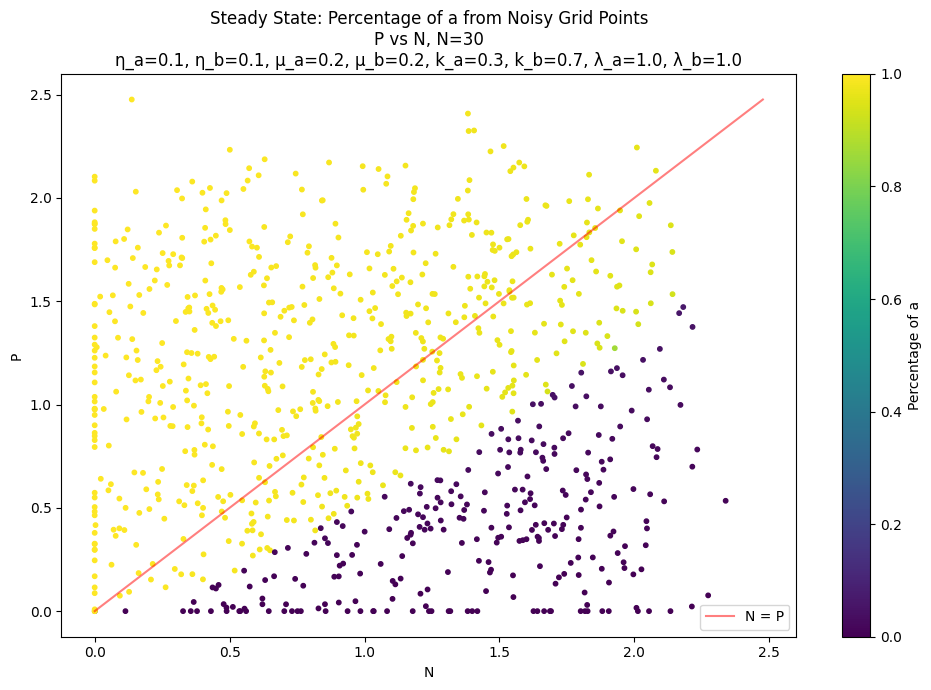
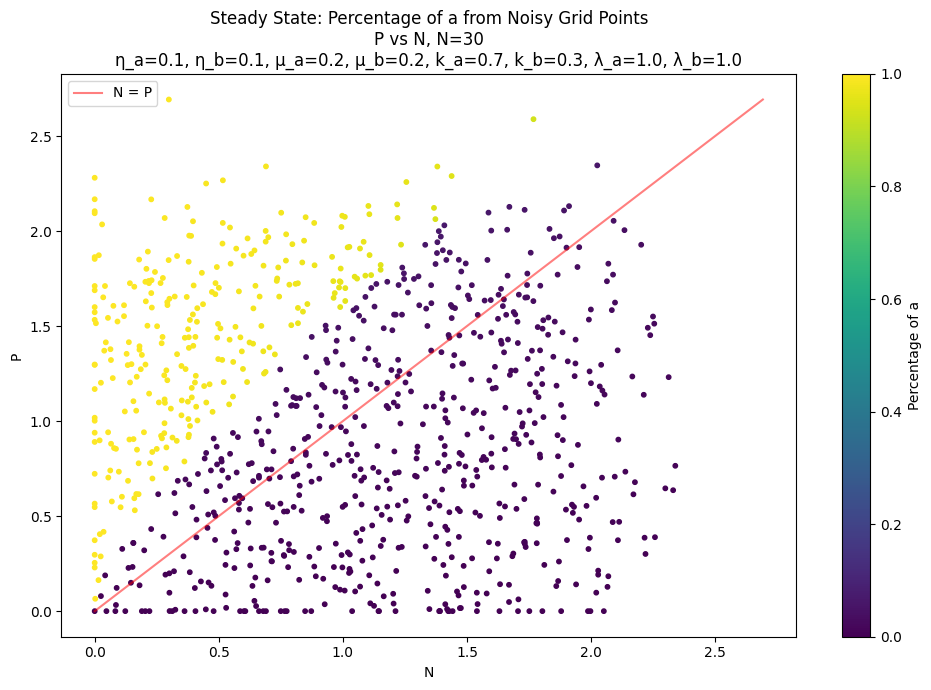

### $\eta_a$ and $\eta_b$

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

FIND A FRONTIER EQUATION WHICH IS A FUNCVTION OF ka lambdaa AND SEE HOW IT BEHAVES AS WE MODIFY THOSE VALUES

### 1.2.3 Convergence time



# Pour le neurone symmetrique on devait considérer $P,N<1.25$ pour assurer la stability. Voir si on peut s'en passer avec d'autres valeurs des parametres